import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [66]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer

import mlflow

from sklearn.metrics import (
    classification_report,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

from sklearn.metrics import ConfusionMatrixDisplay


In [67]:
df = pd.read_csv('insurance.csv')

In [68]:
df.sample(5)

,age,weight,height,income_lpa,smoker,city,occupation,insurance_premium_category
0,67.0,119.8,1.56,2.920000,False,Jaipur,retired,High
97,NaN,NaN,1.80,44.860000,False,Hyderabad,freelancer,Low
64,71.0,117.8,1.78,1.020000,False,Chandigarh,retired,High
94,50.0,105.4,NaN,10.542289,False,Bangalore,government_job,Low
76,NaN,NaN,1.50,1.120000,False,Mysore,retired,High


In [69]:
df['occupation'].unique()

array(['retired', 'freelancer', 'student', 'government_job',
       'business_owner', 'unemployed', 'private_job'], dtype=object)

In [70]:
# check for missing values in data

(
    df
    .isna()
    .sum()
)

age                            8
weight                        11
height                         6
income_lpa                     6
smoker                         0
city                           0
occupation                     0
insurance_premium_category     0
dtype: int64

In [71]:
df_feat = df.copy()

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         92 non-null     float64
 1   weight                      89 non-null     float64
 2   height                      94 non-null     float64
 3   income_lpa                  94 non-null     float64
 4   smoker                      100 non-null    bool   
 5   city                        100 non-null    object 
 6   occupation                  100 non-null    object 
 7   insurance_premium_category  100 non-null    object 
dtypes: bool(1), float64(4), object(3)
memory usage: 5.7+ KB


# Data Cleaning

In [73]:
def clean_data(df):
    return (
        df
        .rename(columns=str.lower)
    )

In [74]:
final_df = clean_data(df)

final_df.head()

,age,weight,height,income_lpa,smoker,city,occupation,insurance_premium_category
0,67.0,119.8,1.56,2.92,False,Jaipur,retired,High
1,36.0,101.1,1.83,34.28,False,Chennai,freelancer,Low
2,39.0,56.8,1.64,36.64,False,Indore,freelancer,Low
3,22.0,109.4,1.55,3.34,True,Mumbai,student,Medium
4,69.0,62.2,1.60,NaN,True,Indore,retired,High


In [75]:
# shape of the cleaned data 

print(f'The cleaned data has {final_df.shape[0]} rows and {final_df.shape[1]} columns')

The cleaned data has 100 rows and 8 columns


In [76]:
# missing values in the cleaned data

(
    final_df
    .isna()
    .sum()
)

age                            8
weight                        11
height                         6
income_lpa                     6
smoker                         0
city                           0
occupation                     0
insurance_premium_category     0
dtype: int64

# EDA

In [107]:
# distribution of target

(
    final_df
    .loc[:,'insurance_premium_category']
    .value_counts(normalize=True)
)

insurance_premium_category
Low       0.34
High      0.33
Medium    0.33
Name: proportion, dtype: float64

In [108]:
# boxplots

def create_boxplot(data,column_name,hue=None):
    sns.boxplot(data=data, y=column_name, hue=hue)

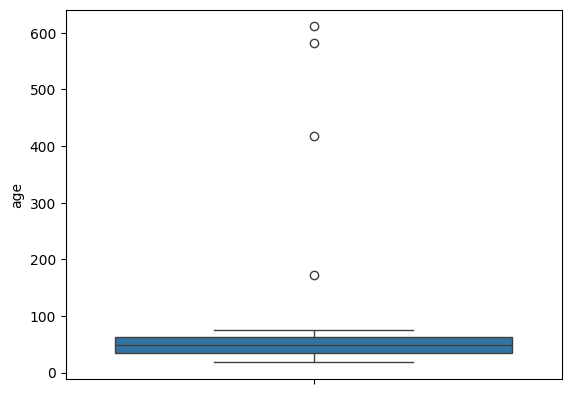

In [109]:
# boxplot for age column
create_boxplot(final_df,'age')

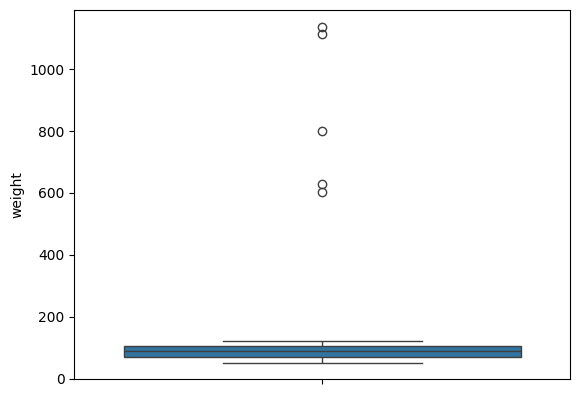

In [110]:
# boxplot for Weight column

create_boxplot(final_df,'weight')

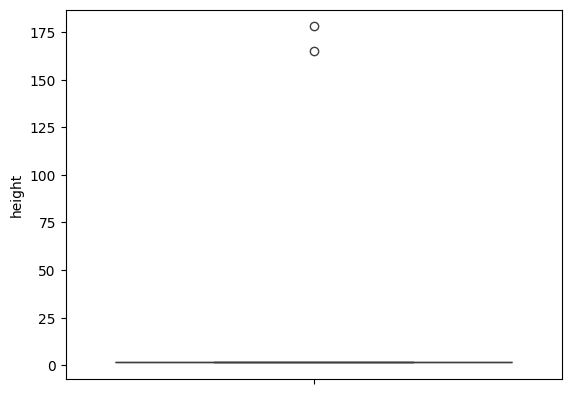

In [111]:
# boxplot for Height column

create_boxplot(final_df,'height')

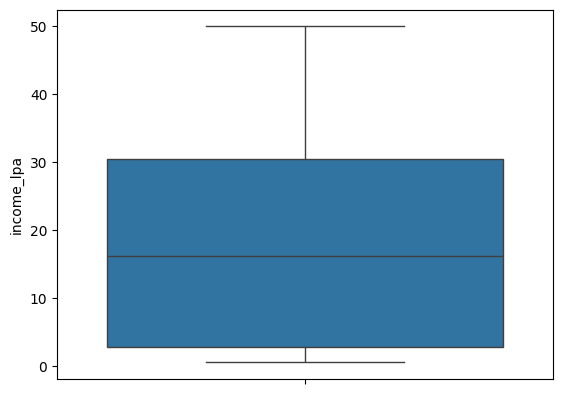

In [112]:
# boxplot for income column

create_boxplot(final_df,'income_lpa')

In [113]:
# plot the distribution of categorical columns

def plot_distribution(data,column_name):
    sns.countplot(data=data, x=column_name)

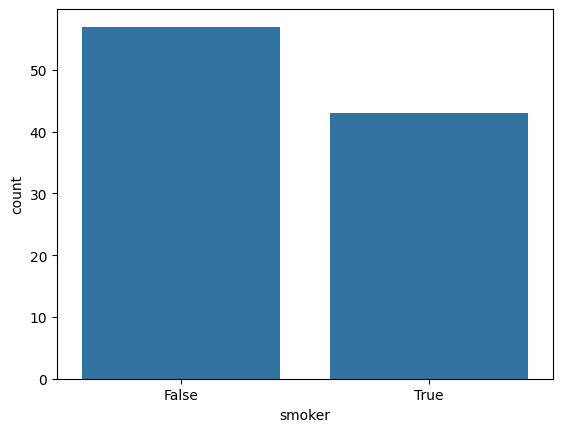

In [114]:
# distribution for smoker
plot_distribution(final_df,'smoker')

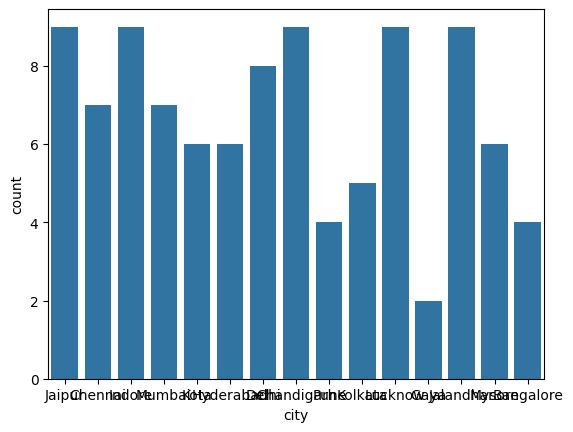

In [115]:
# distribution for city
plot_distribution(final_df,'city')

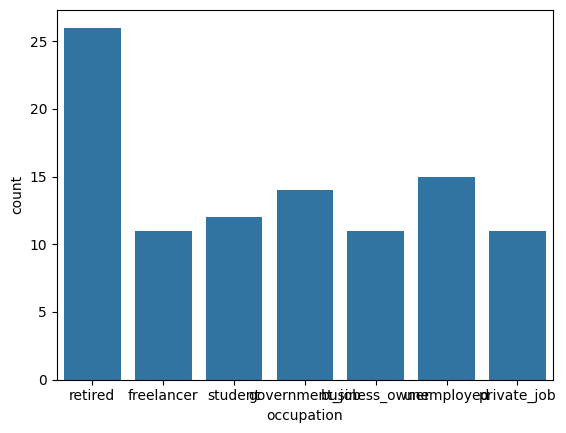

In [116]:
# distribution for occupation 

plot_distribution(final_df,'occupation')

In [186]:
# Feature 1: BMI
df_feat["bmi"] = df_feat["weight"] / (df_feat["height"] ** 2)

In [187]:
# Feature 2: Age Group
def age_group(age):
    if age < 25:
        return "young"
    elif age < 45:
        return "adult"
    elif age < 60:
        return "middle_aged"
    return "senior"

In [188]:
df_feat["age_group"] = df_feat["age"].apply(age_group)

In [189]:
# Feature 3: Lifestyle Risk
def lifestyle_risk(row):
    if row["smoker"] and row["bmi"] > 30:
        return "high"
    elif row["smoker"] or row["bmi"] > 27:
        return "medium"
    else:
        return "low"

In [190]:
df_feat["lifestyle_risk"] = df_feat.apply(lifestyle_risk, axis=1)

In [191]:
tier_1_cities = ["Mumbai", "Delhi", "Bangalore", "Chennai", "Kolkata", "Hyderabad", "Pune"]
tier_2_cities = [
    "Jaipur", "Chandigarh", "Indore", "Lucknow", "Patna", "Ranchi", "Visakhapatnam", "Coimbatore",
    "Bhopal", "Nagpur", "Vadodara", "Surat", "Rajkot", "Jodhpur", "Raipur", "Amritsar", "Varanasi",
    "Agra", "Dehradun", "Mysore", "Jabalpur", "Guwahati", "Thiruvananthapuram", "Ludhiana", "Nashik",
    "Allahabad", "Udaipur", "Aurangabad", "Hubli", "Belgaum", "Salem", "Vijayawada", "Tiruchirappalli",
    "Bhavnagar", "Gwalior", "Dhanbad", "Bareilly", "Aligarh", "Gaya", "Kozhikode", "Warangal",
    "Kolhapur", "Bilaspur", "Jalandhar", "Noida", "Guntur", "Asansol", "Siliguri"
]

In [192]:
# Feature 4: City Tier 

def city_tier(city):
    if city in tier_1_cities:
        return 1
    elif city in tier_2_cities:
        return 2
    else:
        return 3

In [193]:
df_feat["city_tier"] = df_feat["city"].apply(city_tier)

In [205]:
df_feat.drop(columns=['age', 'weight', 'height', 'smoker', 'city'])[['income_lpa', 'occupation', 'bmi', 'age_group', 'lifestyle_risk', 'city_tier', 'insurance_premium_category']].sample(5)

,income_lpa,occupation,bmi,age_group,lifestyle_risk,city_tier,insurance_premium_category
99,28.166640,government_job,27.688778,adult,medium,1,Low
14,13.505166,government_job,0.003280,middle_aged,low,3,Medium
62,35.670000,business_owner,21.738481,adult,low,1,Low
33,1.460000,retired,21.791064,senior,low,1,Medium
93,1.280000,student,23.199416,senior,low,2,Low


In [206]:
# Select features and target
X = df_feat[["bmi", "age_group", "lifestyle_risk", "city_tier", "income_lpa", "occupation"]]
y = df_feat["insurance_premium_category"]

In [207]:
X

,bmi,age_group,lifestyle_risk,city_tier,income_lpa,occupation
0,49.227482,senior,medium,2,2.92000,retired
1,30.189017,adult,medium,1,34.28000,freelancer
2,21.118382,adult,low,2,36.64000,freelancer
3,45.535900,young,high,1,3.34000,student
4,24.296875,senior,medium,2,NaN,retired
...,...,...,...,...,...,...
95,21.420747,adult,low,2,19.64000,business_owner
96,47.984483,adult,medium,1,34.01000,private_job
97,NaN,senior,low,1,44.86000,freelancer
98,30.521676,adult,medium,1,NaN,business_owner


In [208]:
y

0       High
1        Low
2        Low
3     Medium
4       High
       ...  
95       Low
96       Low
97       Low
98       Low
99       Low
Name: insurance_premium_category, Length: 100, dtype: object

In [209]:
# Define categorical and numeric features
categorical_features = ["age_group", "lifestyle_risk", "occupation", "city_tier"]
numeric_features = ["bmi", "income_lpa"]

In [211]:
# age_pipeline
age_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='median')), #handel missing values
    ('outliers',Winsorizer(capping_method='gaussian',fold=3)), # to handel the outliers
    ('scale',StandardScaler()) # standard scalar roust to outliers (-1,1)
])


age_pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('impute', ...), ('outliers', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. 

In [212]:
# Create column transformer for OHE
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

In [217]:
set_config(transform_output='pandas')

In [219]:
# make column column transformer

# Preprocessor: apply to features only (not the target)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])
preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [220]:
# Create a pipeline with preprocessing and random forest classifier
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])
pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [216]:
# Split data and train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify= y)
pipeline.fit(X_train, y_train)


ValueError: Pandas output does not support sparse data. Set sparse_output=False to output pandas dataframes or disable Pandas output via` ohe.set_output(transform="default").

In [168]:
# Predict and evaluate
y_pred = pipeline.predict(X_test)
accuracy_score(y_test, y_pred)

0.6

In [169]:
X_test.sample(5)

,bmi,age_group,lifestyle_risk,city_tier,income_lpa,occupation
46,NaN,adult,medium,1,25.57,unemployed
8,23.233456,senior,low,2,1.78,retired
90,NaN,middle_aged,low,1,21.07,business_owner
15,21.860828,senior,medium,1,NaN,retired
42,21.815799,young,medium,2,2.60,student


In [170]:
import pickle

# Save the trained pipeline using pickle
pickle_model_path = "model.pkl"
with open(pickle_model_path, "wb") as f:
    pickle.dump(pipeline, f)
